In [10]:
"""
Ensure bez2018model has been installed: `python setup.py build_ext --inplace`
"""

import sys
import os
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import bez2018model
import util_figures
import util_stimuli


In [11]:
"""
Generate example stimulus
"""

fs = 32000
dur = 0.150 # <-- duration of stimulus (150 ms tone)
snr = 5.0
dbspl = 60.0

signal = util_stimuli.complex_tone(
    f0=200,
    fs=fs,
    dur=dur,
    harmonic_numbers=np.arange(1, 31),
    frequencies=None,
    amplitudes=None,
    phase_mode='sine',
    offset_start=True,
    strict_nyquist=True)

noise = np.random.randn(signal.shape[0])
y = util_stimuli.combine_signal_and_noise(signal, noise, snr=snr)
y = util_stimuli.set_dBSPL(y, dbspl)

ipd.display(ipd.Audio(y, rate=fs))


In [12]:
"""
Run auditory nerve model
"""

kwargs_nervegram = {
    'nervegram_dur': 0.05, # <-- duration of final nervegram in seconds (<= stimulus duration)
    'nervegram_fs': 20e3, # <-- sampling rate of nervegram in Hz
    'buffer_start_dur': 0.070, # <-- trim first 70ms of the full-length nervegram
    'buffer_end_dur': 0.010, # <-- trim last 10ms of the full-lenght nervegram
    'pin_fs': 100e3,
    'pin_dBSPL_flag': 0,
    'pin_dBSPL': None,
    'species': 2,
    'bandwidth_scale_factor': 1.0, # <-- scale cochlear filter bandwidths
    'cf_list': None,
    'num_cf': 100, # <-- specify 100 freqency channels ERB-spaced between 125 and 14000 Hz
    'min_cf': 125,
    'max_cf': 14e3,
    'max_spikes_per_train': 500,
    'num_spike_trains': 20, # <-- number of spike trains to sample per frequency channel
    'cohc': 1.0,
    'cihc': 1.0,
    'IhcLowPass_cutoff': 3000, # <-- adjust upper frequency limit of auditory nerve phase-locking
    'IhcLowPass_order': 7,
    'spont': 70.0,
    'noiseType': 0,
    'implnt': 0,
    'tabs': 6e-4,
    'trel': 6e-4,
    'random_seed': None,
    'return_vihcs': False, # <-- "nervegram_vihcs" contains instantaneous IHC voltages
    'return_meanrates': True, # <-- "nervegram_meanrates" contains instantaneous firing rates
    'return_spike_times': False,
    'return_spike_tensor_sparse': False,
    'return_spike_tensor_dense': True, # <-- "nervegram_spike_tensor_dense" contains individual spikes
    'nervegram_spike_tensor_fs': 10e3, # <-- sampling rate of spike tensor in Hz
}

### NOTE: run times will be slower if spikes are requested (especially for large `num_spike_trains`)

nervegram_output_dict = bez2018model.nervegram(y, fs, **kwargs_nervegram)
for k in sorted(nervegram_output_dict.keys()):
    if len(np.array(nervegram_output_dict[k]).shape) == 0:
        print(k, np.array(nervegram_output_dict[k]).shape, nervegram_output_dict[k])
    else:
        print(k, np.array(nervegram_output_dict[k]).shape, np.array(nervegram_output_dict[k]).dtype)


IhcLowPass_cutoff () 3000
IhcLowPass_order () 7
bandwidth_scale_factor (100,) float32
buffer_end_dur () 0.01
buffer_start_dur () 0.07
cf_list (100,) float32
cihc (100,) float64
cohc (100,) float64
implnt () 0
max_spikes_per_train () 500
nervegram_dur () 0.05
nervegram_fs () 20000.0
nervegram_meanrates (100, 1000) float32
nervegram_spike_tensor_dense (20, 100, 500) bool
nervegram_spike_tensor_fs () 10000.0
noiseType () 0
num_spike_trains () 20
pin (5000,) float32
pin_dBSPL () 59.96643569271874
pin_dBSPL_flag () 0
pin_fs () 100000.0
signal (1600,) float32
signal_fs () 32000
species () 2
spont () 70.0
synapseMode () 0
tabs () 0.0006
trel () 0.0006


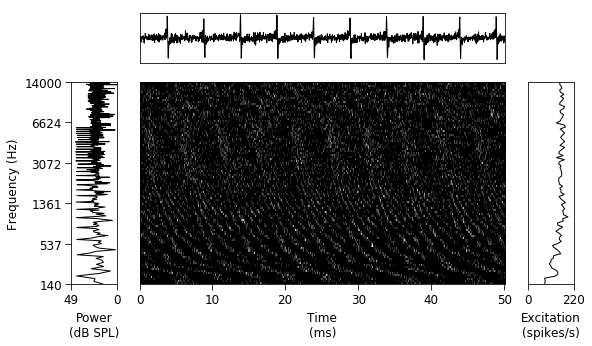

In [14]:
"""
Visualize stimulus and simulated auditory nerve representations
"""

PLOT_SPIKES = True 

figsize=(9, 5)
nrows=2
ncols=3
gridspec_kw = {
    'wspace': 0.15,
    'hspace': 0.15,
    'width_ratios': [1, 8, 1],
    'height_ratios': [1, 4],
}

waveform = nervegram_output_dict['signal']
sr_waveform = nervegram_output_dict['signal_fs']
cfs = nervegram_output_dict['cf_list']

if PLOT_SPIKES:
    # If PLOT_SPIKES == True, plot spike trains summed within frequency channels
    n_anf = nervegram_output_dict['nervegram_spike_tensor_dense'].shape[0]
    nervegram = nervegram_output_dict['nervegram_spike_tensor_dense'].sum(axis=0)
    sr_nervegram = nervegram_output_dict['nervegram_spike_tensor_fs']
else:
    # If PLOT_SPIKES == False, plot instantaneous firing rate approximation
    n_anf = None
    nervegram = nervegram_output_dict['nervegram_meanrates']
    sr_nervegram = nervegram_output_dict['nervegram_fs']

fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, gridspec_kw=gridspec_kw)
util_figures.make_stimulus_summary_plot(
    ax_arr,
    ax_idx_waveform=1,
    ax_idx_spectrum=3,
    ax_idx_nervegram=4,
    ax_idx_excitation=5,
    waveform=waveform,
    nervegram=nervegram,
    sr_waveform=sr_waveform,
    sr_nervegram=sr_nervegram,
    cfs=cfs,
    n_anf=n_anf)
plt.tight_layout()
plt.show()
